#### 필요한 라이브러리 및 데이터 불러오기 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt 
#import plotly.graph_objects as go
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

labelencoder = LabelEncoder()
%matplotlib inline


froot='https://raw.githubusercontent.com/JiwooKimm/Personal_Projects/master/Forecaster_Airpollutant_Seoul/datasets/'
fname= 'Measurement_summary.csv'

data= pd.read_csv(froot+fname)
data.head()

,Measurement date,Station code,Address,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5
0,2017-01-01 00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.059,0.002,1.2,73.0,57.0
1,2017-01-01 01:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.058,0.002,1.2,71.0,59.0
2,2017-01-01 02:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.056,0.002,1.2,70.0,59.0
3,2017-01-01 03:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.056,0.002,1.2,70.0,58.0
4,2017-01-01 04:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.003,0.051,0.002,1.2,69.0,61.0


In [2]:
from datetime import datetime 
data['Measurement date'] = pd.to_datetime(data['Measurement date'])
data.set_index('Measurement date', drop=True, inplace=True)

#### 데이터 확인, 결측치(missing value) 및 이상치(outlier) 처리 

##### i. 데이터 확인  

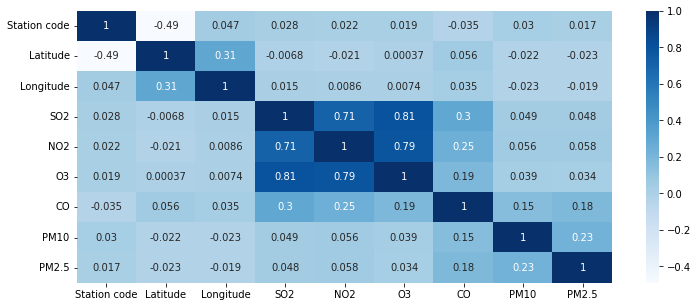

In [2]:
cols = data.columns[:50]
plt.figure(figsize = (12,5))
sns.heatmap(data[cols].corr(), annot = True, cmap= 'Blues')
plt.show()

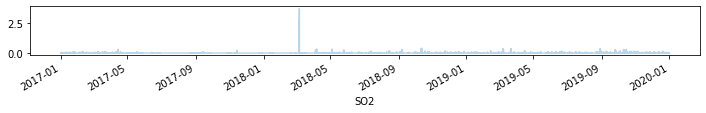

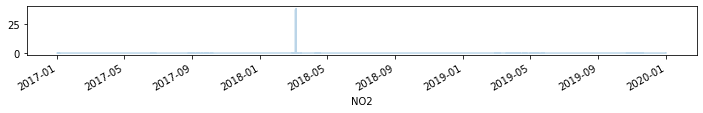

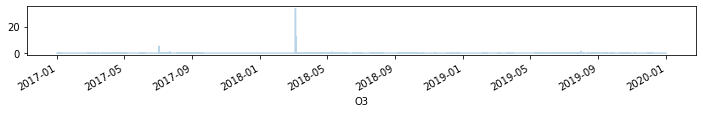

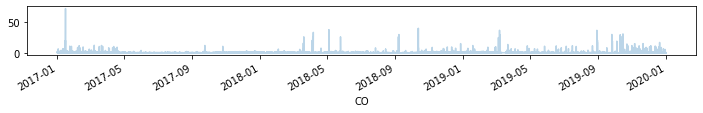

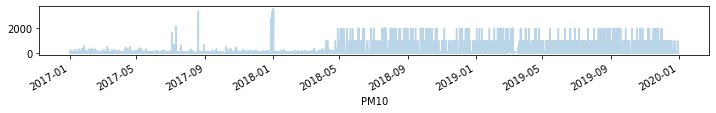

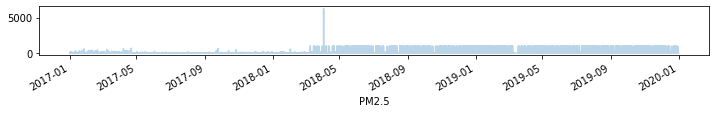

In [17]:
# 데이터 확인 

for i in range(6):
  plt.figure(figsize=(12,1))
  d= data.iloc[:,4+i]
  d[d >= 0 ].plot(alpha=0.3)
  
  plt.xlabel(str(data.columns[4+i]))
  plt.show()

In [ ]:
#check Null
data.describe() 

,Station code,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5
count,647511.000000,647511.000000,647511.000000,647511.000000,647511.000000,647511.000000,647511.000000,647511.000000,647511.000000
mean,113.000221,37.553484,126.989340,-0.001795,0.022519,0.017979,0.509197,43.708051,25.411995
std,7.211315,0.053273,0.078790,0.078832,0.115153,0.099308,0.405319,71.137342,43.924595
min,101.000000,37.452357,126.835151,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,107.000000,37.517528,126.927102,0.003000,0.016000,0.008000,0.300000,22.000000,11.000000
50%,113.000000,37.544962,127.004850,0.004000,0.025000,0.021000,0.500000,35.000000,19.000000
75%,119.000000,37.584848,127.047470,0.005000,0.038000,0.034000,0.600000,53.000000,31.000000
max,125.000000,37.658774,127.136792,3.736000,38.445000,33.600000,71.700000,3586.000000,6256.000000


In [18]:
#check num of NaN
data.isna().sum()


Station code    0
Address         0
Latitude        0
Longitude       0
SO2             0
NO2             0
O3              0
CO              0
PM10            0
PM2.5           0
dtype: int64

##### ii. 결측치 처리 
nan value는 없지만, 대기 중 오염물질의 농도가 음수일 수 는 없으므로, -1로 결측값을 채워 놓은 것 같다.

또한, 그래프를 보아 이상치라 의심할 만 한 것들이 많지 않게 있는 것 같다. 

**처리 전략**
- 결측치 처리: 채워진 결측값을 다시 nan value
- 이상치 처리: 이상치를 탐색하고 nan value 처리 해준다.
- 보간: 처리된 nan value들을 quadratic interpolation 해주어 근사한다.


In [19]:
data.iloc[852:857,4:]

,SO2,NO2,O3,CO,PM10,PM2.5
Measurement date,,,,,,
2017-02-05 12:00:00,0.003,0.030,0.020,0.5,18.0,12.0
2017-02-05 13:00:00,0.003,0.032,0.017,0.5,22.0,16.0
2017-02-05 14:00:00,-1.000,-1.000,-1.000,-1.0,-1.0,-1.0
2017-02-05 15:00:00,-1.000,-1.000,-1.000,-1.0,-1.0,-1.0
2017-02-05 16:00:00,-1.000,-1.000,-1.000,-1.0,-1.0,-1.0


In [8]:
data.columns

Index(['Station code', 'Address', 'Latitude', 'Longitude', 'SO2', 'NO2', 'O3',
       'CO', 'PM10', 'PM2.5'],
      dtype='object')

In [3]:
raw_data=data.copy()
for col in data.columns[4:] :
  data.loc[data[col] < 0, col] = np.nan

In [22]:
data.iloc[852:857,4:]

,SO2,NO2,O3,CO,PM10,PM2.5
Measurement date,,,,,,
2017-02-05 12:00:00,0.003,0.030,0.020,0.5,18.0,12.0
2017-02-05 13:00:00,0.003,0.032,0.017,0.5,22.0,16.0
2017-02-05 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-05 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-05 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN


잘 처리됨. 

##### iii. 이상치 처리
대부분 0 근처의 값을 가지고 있고, 이상치 광범위하게 이상치 분포

IQR 이용하여 outlier 정의하고 nan value 처리 해주겠음.

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FcAqc6V%2FbtqyQLiddUd%2FiXQVu1nYTo2rx3Q8xZBqy0%2Fimg.png" width= 400>

In [4]:
for col in data.columns[4:]:

  Q1 = np.nanpercentile(data[col], 25) # nan-value 제외하고 집계
  Q3 = np.nanpercentile(data[col], 75)
  IQR = Q3 - Q1
  outlier_step = 1.5 * IQR

  # outlier_list_col= df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
  data.loc[(data[col] < Q1 - outlier_step)|(data[col] > Q3 + outlier_step), col] = np.nan



##### iV. NaN value 보간

In [5]:
itp_data=data.copy()
itp_data.head(1)

,Station code,Address,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5
Measurement date,,,,,,,,,,
2017-01-01,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.059,0.002,NaN,73.0,57.0


In [6]:
# 결측치 spline 보간
for col in itp_data.columns[4:]: 
  col_new= itp_data[col].interpolate(method='time')

  itp_data[col]=col_new

itp_data.describe()

/usr/local/lib/python3.7/dist-packages/IPython/core/inputtransformer2.py:481: UserWarning: `make_tokens_by_line` received a list of lines which do not have lineending markers ('\n', '\r', '\r\n', '\x0b', '\x0c'), behavior will be unspecified
  warnings.warn("`make_tokens_by_line` received a list of lines which do not have lineending markers ('\\n', '\\r', '\\r\\n', '\\x0b', '\\x0c'), behavior will be unspecified")


,Station code,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5
count,647511.000000,647511.000000,647511.000000,647511.000000,647511.000000,647511.000000,647504.000000,647511.000000,647511.000000
mean,113.000221,37.553484,126.989340,0.004193,0.028067,0.023653,0.496038,38.904256,22.152699
std,7.211315,0.053273,0.078790,0.001525,0.015340,0.017679,0.204423,23.144889,14.526268
min,101.000000,37.452357,126.835151,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,107.000000,37.517528,126.927102,0.003000,0.016000,0.009000,0.300000,22.000000,11.000000
50%,113.000000,37.544962,127.004850,0.004000,0.025000,0.021000,0.500000,35.000000,19.000000
75%,119.000000,37.584848,127.047470,0.005000,0.038000,0.034000,0.600000,52.000000,30.000000
max,125.000000,37.658774,127.136792,0.008000,0.071000,0.074000,1.000000,99.000000,61.000000


In [27]:
itp_data.iloc[852:857, 4:]

,SO2,NO2,O3,CO,PM10,PM2.5
Measurement date,,,,,,
2017-02-05 12:00:00,0.003,0.030,0.020,0.5,18.0,12.0
2017-02-05 13:00:00,0.003,0.032,0.017,0.5,22.0,16.0
2017-02-05 14:00:00,0.003,0.031,0.017,0.4,17.0,9.0
2017-02-05 15:00:00,0.004,0.028,0.018,0.4,20.0,9.0
2017-02-05 16:00:00,0.004,0.029,0.027,0.6,16.0,17.0


결측치 때 nan-value 처리하고 확인했을 때와 동일한 time stamp의 데이터를 보았을 때 얼추 잘 보간 된 것 같다. 

In [33]:
# data.set_index('Measurement date', drop=True, inplace= True)
itp_data.head(10)

,Station code,Address,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5
Measurement date,,,,,,,,,,
2017-01-01 00:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.059,0.002,NaN,73.0,57.0
2017-01-01 01:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.058,0.002,NaN,71.0,59.0
2017-01-01 02:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.056,0.002,NaN,70.0,59.0
2017-01-01 03:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.056,0.002,NaN,70.0,58.0
2017-01-01 04:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.003,0.051,0.002,NaN,69.0,61.0
2017-01-01 05:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.003,0.046,0.002,NaN,70.0,61.0
2017-01-01 06:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.003,0.049,0.002,NaN,66.0,57.0
2017-01-01 07:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.003,0.045,0.002,1.0,71.0,60.0
2017-01-01 08:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.047,0.002,1.0,72.0,60.0


In [7]:
itp_data.isna().sum()

Station code    0
Address         0
Latitude        0
Longitude       0
SO2             0
NO2             0
O3              0
CO              7
PM10            0
PM2.5           0
dtype: int64

In [8]:
# CO 0~7번 데이터는 보간이 안된다...<ㅠ
# NOCB 하겠음

itp_data.iloc[:7, 7]=itp_data.iloc[8,7]
itp_data.head(10)

,Station code,Address,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5
Measurement date,,,,,,,,,,
2017-01-01 00:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.059,0.002,1.0,73.0,57.0
2017-01-01 01:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.058,0.002,1.0,71.0,59.0
2017-01-01 02:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.056,0.002,1.0,70.0,59.0
2017-01-01 03:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.056,0.002,1.0,70.0,58.0
2017-01-01 04:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.003,0.051,0.002,1.0,69.0,61.0
2017-01-01 05:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.003,0.046,0.002,1.0,70.0,61.0
2017-01-01 06:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.003,0.049,0.002,1.0,66.0,57.0
2017-01-01 07:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.003,0.045,0.002,1.0,71.0,60.0
2017-01-01 08:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.047,0.002,1.0,72.0,60.0


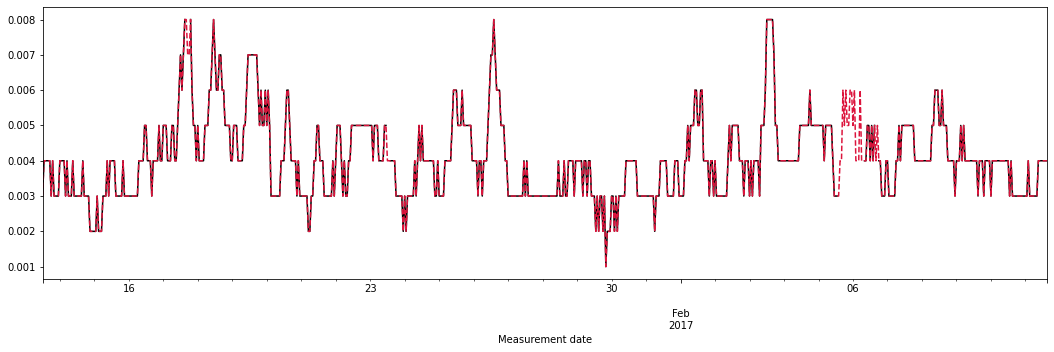

In [9]:
plt.figure(figsize=(18,5))

data.iloc[300:1000, 4].plot(c="black")
itp_data.iloc[300:1000, 4].plot(alpha=1, ls='--', c='crimson')
# plt.ylim(0,0.01)
# plt.plot(itp_data.iloc[: , 3])
plt.show()

##### 지역구 데이터 분리



In [10]:
def prep_data(data,gu):
  df= data[data['Station code'] == gu]
  df.drop(['Station code', 'Address','Latitude','Longitude'], axis=1, inplace= True)
  df= df[['SO2',	'NO2',	'CO',	'PM10',	'PM2.5',	'O3']]
  return df

gu= 101 #종로
df= prep_data(itp_data,gu)

df.head(10)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,SO2,NO2,CO,PM10,PM2.5,O3
Measurement date,,,,,,
2017-01-01 00:00:00,0.004,0.059,1.0,73.0,57.0,0.002
2017-01-01 01:00:00,0.004,0.058,1.0,71.0,59.0,0.002
2017-01-01 02:00:00,0.004,0.056,1.0,70.0,59.0,0.002
2017-01-01 03:00:00,0.004,0.056,1.0,70.0,58.0,0.002
2017-01-01 04:00:00,0.003,0.051,1.0,69.0,61.0,0.002
2017-01-01 05:00:00,0.003,0.046,1.0,70.0,61.0,0.002
2017-01-01 06:00:00,0.003,0.049,1.0,66.0,57.0,0.002
2017-01-01 07:00:00,0.003,0.045,1.0,71.0,60.0,0.002
2017-01-01 08:00:00,0.004,0.047,1.0,72.0,60.0,0.002


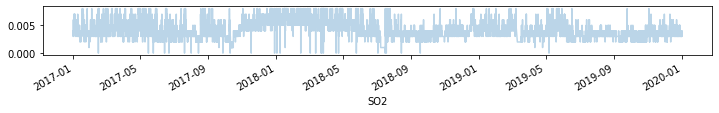

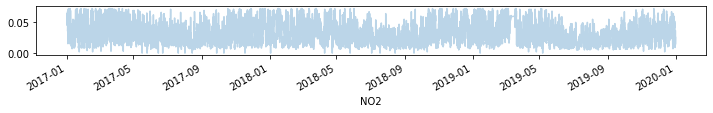

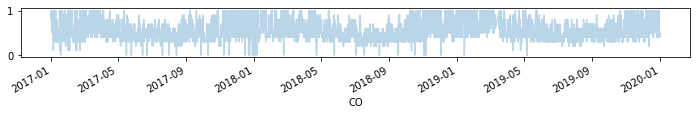

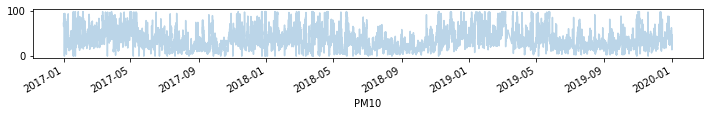

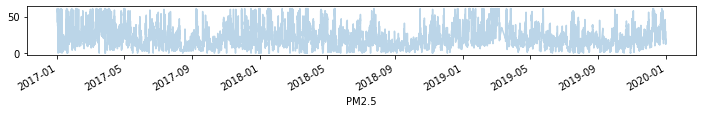

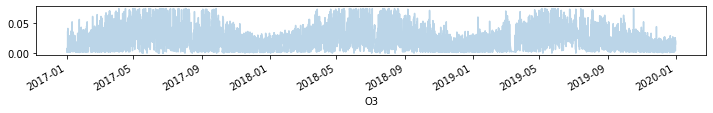

                SO2           NO2            CO          PM10         PM2.5  \
count  25905.000000  25905.000000  25905.000000  25905.000000  25905.000000   
mean       0.004174      0.031156      0.549122     36.146342     21.181683   
std        0.001421      0.015599      0.193750     21.263739     13.744547   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.003000      0.019000      0.400000     21.000000     11.000000   
50%        0.004000      0.028000      0.500000     32.000000     18.000000   
75%        0.005000      0.042000      0.700000     47.000000     28.000000   
max        0.008000      0.071000      1.000000     99.000000     61.000000   

                 O3  
count  25905.000000  
mean       0.024092  
std        0.017461  
min        0.000000  
25%        0.009000  
50%        0.022000  
75%        0.035000  
max        0.074000  


In [11]:
for col in df.columns:
  plt.figure(figsize=(12,1))
  d= df[col]
  d.plot(alpha=0.3)
  plt.xlabel(str(col))
  plt.show()
print(df.describe())  

#### 학습 - 검증 데이터 분리 & 정규화


In [22]:
from sklearn.preprocessing import MinMaxScaler

# 7일간의 데이터가 입력으로 들어가고 batch size는 임의로 지정
seq_length = 30*24
batch = 100

# 전체 데이터의 70% 학습, 30% 테스트에 사용 
train_size = int(df.shape[0]*0.7)
train_set = df[0:train_size]  
test_set = df[(train_size - seq_length) : ]


## Data Normalization (0~1) :: 데이터의 단위가 모두 다르기 때문에 꼭! 해주어야함 
# Input scale
mM_x = MinMaxScaler()
mM_x.fit(train_set.iloc[:, :-1])

train_set.iloc[:, :-1] = mM_x.transform(train_set.iloc[:, :-1])
test_set.iloc[:, :-1] = mM_x.transform(test_set.iloc[:, :-1])

# Output scale
mM_y = MinMaxScaler()
mM_y.fit(train_set.iloc[:, [-1]])

train_set.iloc[:, -1] = mM_y.transform(train_set.iloc[:, [-1]])
test_set.iloc[:, -1] = mM_y.transform(test_set.iloc[:, [-1]])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

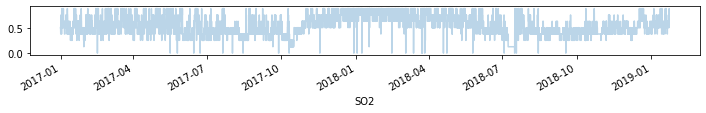

17436


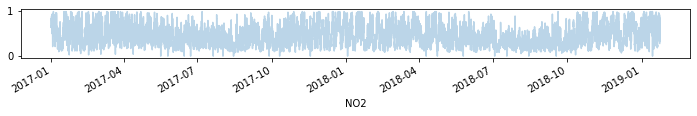

17979


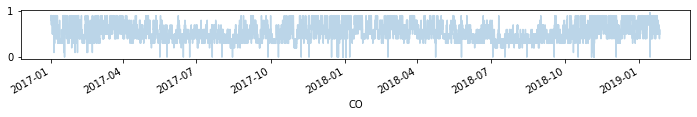

17265


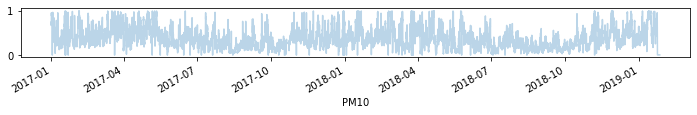

18094


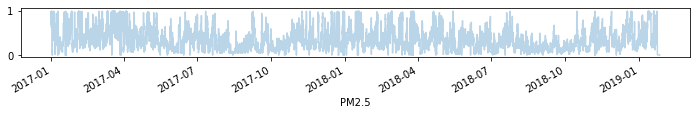

18053


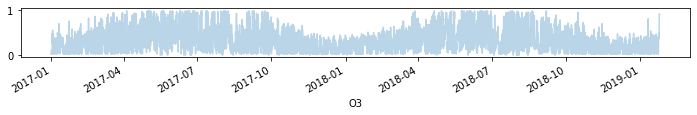

18016


In [13]:
for col in train_set.columns:
  plt.figure(figsize=(12,1))
  d= train_set.loc[train_set[col]<1][col]
  d.plot(alpha=0.3)
  plt.xlabel(str(col))
  plt.show()
  print(d.count())


#### 데이터셋 생성 및 텐서 형태로 변환
- 파이토치에서는 3D 텐서 입력 받음!
  - `torch.FloatTensor`를 사용하여 *np.arrary* 형태에서 *tensor* 형태로 바꿔줘야함.

- 파이토치에서는 데이터를 좀 더 쉽게 다룰 수 있는 유용한 도구로 `Dataset`과 `DataLoader`를 제공

  - 미니 배치 학습, 데이터 셔플, 병렬 처리 등 간단히 수행 ㄱㄴ 

  - 기본적인 사용 방법은 Dataset을 정의하고 -> DataLoader에 전달

In [23]:
import torch
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

# 데이터셋 생성 함수
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series)-seq_length):
        _x = time_series[i:i+seq_length, :]
        _y = time_series[i+seq_length, [-1]]
        # print(_x, "-->",_y)
        dataX.append(_x)
        dataY.append(_y)

    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(np.array(train_set), seq_length)
testX, testY = build_dataset(np.array(test_set), seq_length)

# 텐서로 변환
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

# 텐서 형태로 데이터 정의
dataset = TensorDataset(trainX_tensor, trainY_tensor)

# 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
dataloader = DataLoader(dataset,
                        batch_size=batch,
                        shuffle=True,  
                        drop_last=True)

#### LSTM 모델 정의

<img src="https://miro.medium.com/max/1156/1*laH0_xXEkFE0lKJu54gkFQ.png" width=500 align="center">

*initial setting*
- input size: 6 
- hidden size: 10 
- output size: 1
- learning rate: 0.02


In [24]:
# 설정값
data_dim = 6
hidden_dim = 18
output_dim = 1 
learning_rate = 0.002
nb_epochs = 600


class Net(nn.Module):
    # # 기본변수, layer를 초기화해주는 생성자
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=layers,
                            # dropout = 0.1,
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias = True) 
        
    # 학습 초기화를 위한 함수
    def reset_hidden_state(self): 
        self.hidden = (
                torch.zeros(self.layers, self.seq_len, self.hidden_dim),
                torch.zeros(self.layers, self.seq_len, self.hidden_dim))
    
    # 예측을 위한 함수
    def forward(self, x):
        x, _status = self.lstm(x)
        x = self.fc(x[:, -1])
        return x

#### 학습 
**early stopping** epoch 지나도 학습의 효과가 보이지 않으면 중단!



In [25]:
def train_model(model, train_df, num_epochs = None, lr = None, verbose = 10, patience = 10):
     
    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    nb_epochs = num_epochs
    
    # epoch마다 loss 저장
    train_hist = np.zeros(nb_epochs)

    for epoch in range(nb_epochs):
        avg_cost = 0
        total_batch = len(train_df)
        
        for batch_idx, samples in enumerate(train_df):

            x_train, y_train = samples
            
            # seq별 hidden state reset
            model.reset_hidden_state()
            
            # H(x) 계산
            outputs = model(x_train)
                
            # cost 계산
            loss = criterion(outputs, y_train)                    
            
            # cost로 H(x) 개선
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            avg_cost += loss/total_batch
               
        train_hist[epoch] = avg_cost        
        
        if epoch % verbose == 0:
            print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))
            
        # patience번째 마다 early stopping 여부 확인
        if (epoch % patience == 0) & (epoch != 0):
            
            # loss가 커졌다면 early stop
            if train_hist[epoch-patience] < train_hist[epoch]:
                print('\n Early Stopped')
                
                break
            
    return model.eval(), train_hist

In [26]:
# 모델 학습
net = Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)  
model, train_hist = train_model(net, dataloader, num_epochs = nb_epochs, lr = learning_rate, verbose = 10, patience = 10)

Epoch: 0000 train loss : 0.0012
Epoch: 0010 train loss : 0.0002
Epoch: 0020 train loss : 0.0002
Epoch: 0030 train loss : 0.0002
Epoch: 0040 train loss : 0.0002
Epoch: 0050 train loss : 0.0002
Epoch: 0060 train loss : 0.0002
Epoch: 0070 train loss : 0.0002
Epoch: 0080 train loss : 0.0002
Epoch: 0090 train loss : 0.0001
Epoch: 0100 train loss : 0.0001
Epoch: 0110 train loss : 0.0001

 Early Stopped


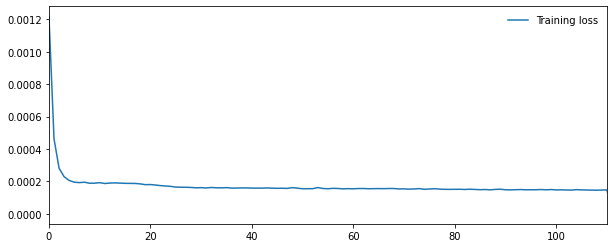

In [28]:

# epoch별 손실값
fig = plt.figure(figsize=(10, 4))
plt.plot(train_hist, label="Training loss")
plt.legend(frameon=False)
plt.xlim(0,110)
plt.show()

#### 모델 저장


In [29]:
from google.colab import files
# 모델 저장    
PATH = "./Airpollution_Seoul_LSTM_.pth"
torch.save(model.state_dict(), PATH)
files.download(PATH)

# 불러오기

model = Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)  
model.load_state_dict(torch.load(PATH), strict=False)
model.eval()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Net(
  (lstm): LSTM(6, 18, batch_first=True)
  (fc): Linear(in_features=18, out_features=1, bias=True)
)

#### 평가

In [40]:
# 예측 테스트
with torch.no_grad(): 
    pred = []
    for pr in range(len(testX_tensor)):

        model.reset_hidden_state()

        predicted = model(torch.unsqueeze(testX_tensor[pr], 0))
        predicted = torch.flatten(predicted).item()
        pred.append(predicted)

    
    #..?갑툭튀 첫 값은 조작,,
    pred[0:5]= np.zeros(5)+sum(pred)/len(pred) # pred[10:20] 
    for p in range(len(pred)):
      if pred[p] < 0:
        if (pred[p-1] >= 0) & (pred[p+1] >= 0):
          pred[p]= (pred[p-1]+pred[p+1])/2
        elif (pred[p-1] >= 0):
          pred[p]= pred[p-1]
        elif (pred[p+1] >= 0):
          pred[p]= pred[p+1]
        else:
          pred[p]= sum(pred)/len(pred)  

    
    # INVERSE
    pred_inverse = mM_y.inverse_transform(np.array(pred).reshape(-1, 1))
    testY_inverse = mM_y.inverse_transform(testY_tensor)

def scoring(true, pred):
  r2= round(metrics.r2_score(true, pred),3)
  corr= round(np.corrcoef(true, pred)[0,1],3) 
  mape= round(metrics.mean_absolute_percentage_error(true, pred)*100,3)
  rmse= round(metrics.mean_squared_error(true, pred, squared=False),3)
  acc= round(metrics.explained_variance_score(true, pred),3)
  mae= np.mean(np.abs(true-pred))
  
  df= pd.DataFrame({ "R2":   r2,
                     "Corr": corr,
                     "RMSE": rmse,
                     "MAPE": mape,
                     "MAE": mae,
                     "Accuracy": acc},
                     
                    index=[0])
  return df

scoring(pred_inverse, testY_inverse)


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


,R2,Corr,RMSE,MAPE,MAE,Accuracy
0,0.894,NaN,0.07,30.722,0.045741,0.895


8492


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

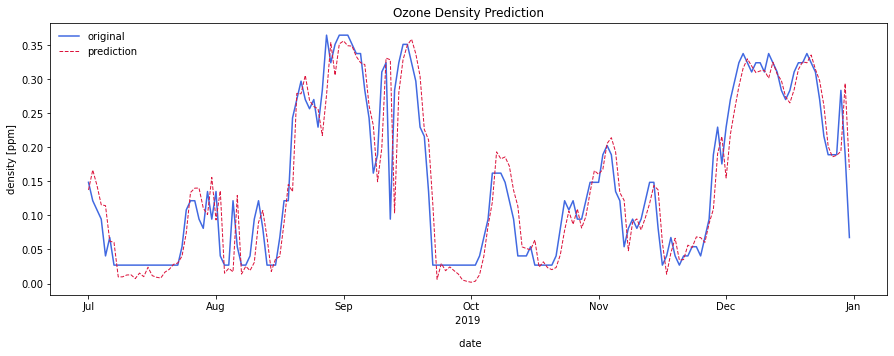

In [56]:
numo3= test_set.shape[0]
print(numo3)
# tickname=(np.arange(0,5)*round(numo3/4))
# tickname=np.arange(0,5)*(120/4)
tickname=np.arange(0,7)*round(180/6)

# ticklabels=np.array(['Jan','Mar','Jun','Sep','Dec'])
# ticklabels=np.array(['Sep','Oct','Nov','Dec','Jan'])
ticklabels=np.array(['Jul','Aug','Sep','Oct','Nov','Dec','Jan'])

plt.figure(figsize=(15,5))
# plt.plot(np.arange(len(testY_inverse)), testY_inverse, label = 'original',  c='royalblue')
# plt.plot(np.arange(len(pred_inverse)), pred_inverse, label = 'prediction', c='crimson',  ls='--', lw=1)
# plt.plot(testY_inverse[-120:], label = 'original',  c='royalblue')
# plt.plot(pred_inverse[-120:], label = 'prediction', c='crimson',  ls='--', lw=1)

plt.plot(testY_inverse[-180:], label = 'original',  c='royalblue')
plt.plot(pred_inverse[-180:], label = 'prediction', c='crimson',  ls='--', lw=1)


plt.title('Ozone Density Prediction')
plt.xlabel('2019 \n\n date')
plt.ylabel('density [ppm]')
plt.legend(frameon=False)
plt.xticks(ticks=tickname,labels=ticklabels)


plt.savefig('./AirPollution_Seoul_LSTM_v3.png')
files.download('./AirPollution_Seoul_LSTM_v3.png')
plt.show()